Importing libraries in order to be able to follow along the tutorial

In [1]:
import numpy as np
import sep
import astropy.io.fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Opening the fits image using astropy.io.fits library and setting its data to the variable called data

In [3]:
hdul = astropy.io.fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = hdul[0].data
data = data.byteswap().newbyteorder()

Displaying and saving the fits image that was read within the previous cell

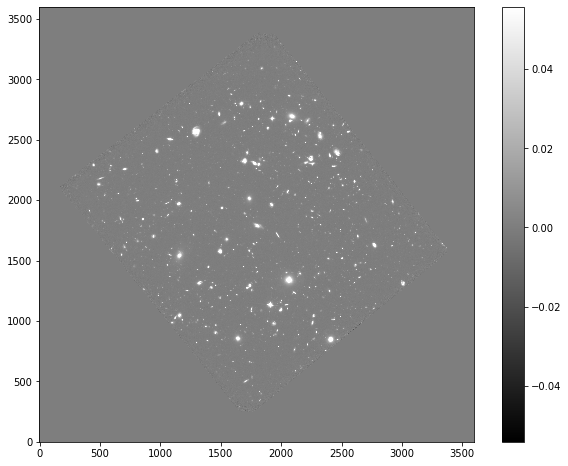

In [4]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("ImageOf105WFile.png", format='png')

Background Estimation using SEP

In [5]:
bkg = sep.Background(data)

Printing the global mean and noise from the Background Estimation in the previous cell

In [6]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Storing the Background as a 2D array in order to be able to display it as an image later on.

In [7]:
bkg_image = bkg.back()

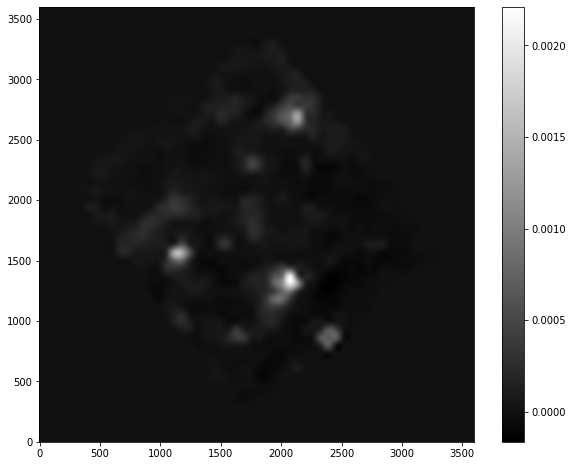

In [8]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("BGImageOf105WFile.png", format='png')

Storing the background noise as a 2D array in order to display it

In [9]:
bkg_rms = bkg.rms()

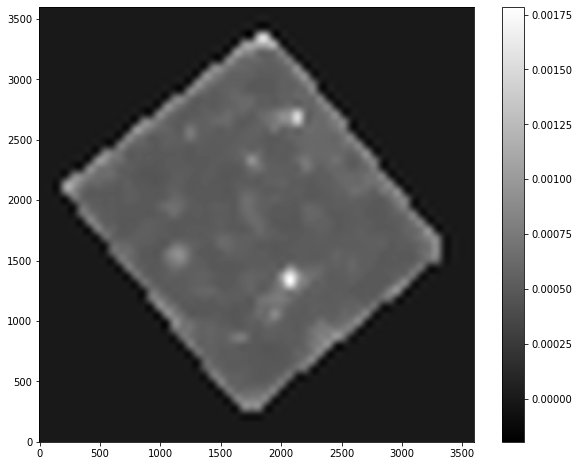

In [10]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("BGNoiseImageOf105WFile.png", format='png')

Removing the background Data from the original data set

In [11]:
data_sub = data - bkg

Calculating the amount of objects within the image

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [13]:
len(objects)

8646

Drawing ellipses around the objects using data_sub

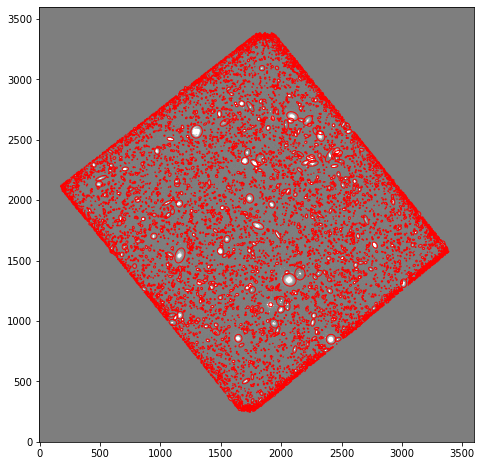

In [14]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("ObjectsImageOf105WFile.png", format='png')

In [15]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Calculating the distribution of fluxes

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [17]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


What is done in this cell:
1. Calculating the number of sources
2. Mean, median, and standdard deviation of the distribution of fluxes
3. Finding the largest outlier in the distribution and where it is in the image along with how many standard deviations it is from the mean

Amount of Sources found: 8646
Flux Mean: 0.36159539075495284
Flux Median: 0.03097589430617518
Flux Standard Deviation: 9.24028235192194
Largest Outlier: 807.2972835731507
Outlier's Standard Deviations from the mean:  87.32803365197564


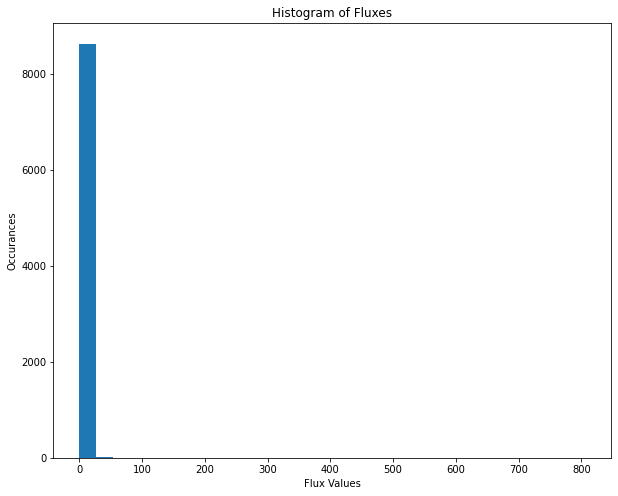

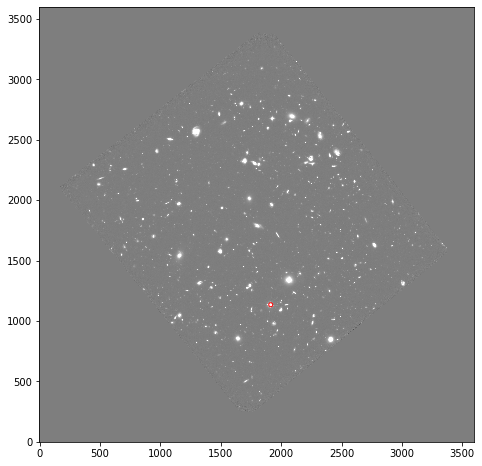

In [18]:
print("Amount of Sources found:", len(flux))

mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)
outlier = max(flux)
print("Flux Mean:", mean)
print("Flux Median:", median)
print("Flux Standard Deviation:", std)
print("Largest Outlier:", outlier)
print("Outlier's Standard Deviations from the mean: ", abs(outlier - mean) / std)

# Histogram of the sources flux
plt.hist(flux, bins=30)
plt.title("Histogram of Fluxes")
plt.xlabel("Flux Values")
plt.ylabel("Occurances")
plt.savefig("HistogramOfFlux.png", format="png")

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# Location of the outlier within the histogram
i = flux.argmax()
e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
            width=6*objects['a'][i],
            height=6*objects['b'][i],
            angle=objects['theta'][i] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)

plt.savefig("LocationOfLargestOutlier.png", format="png")

3-color false image of the UDF using RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


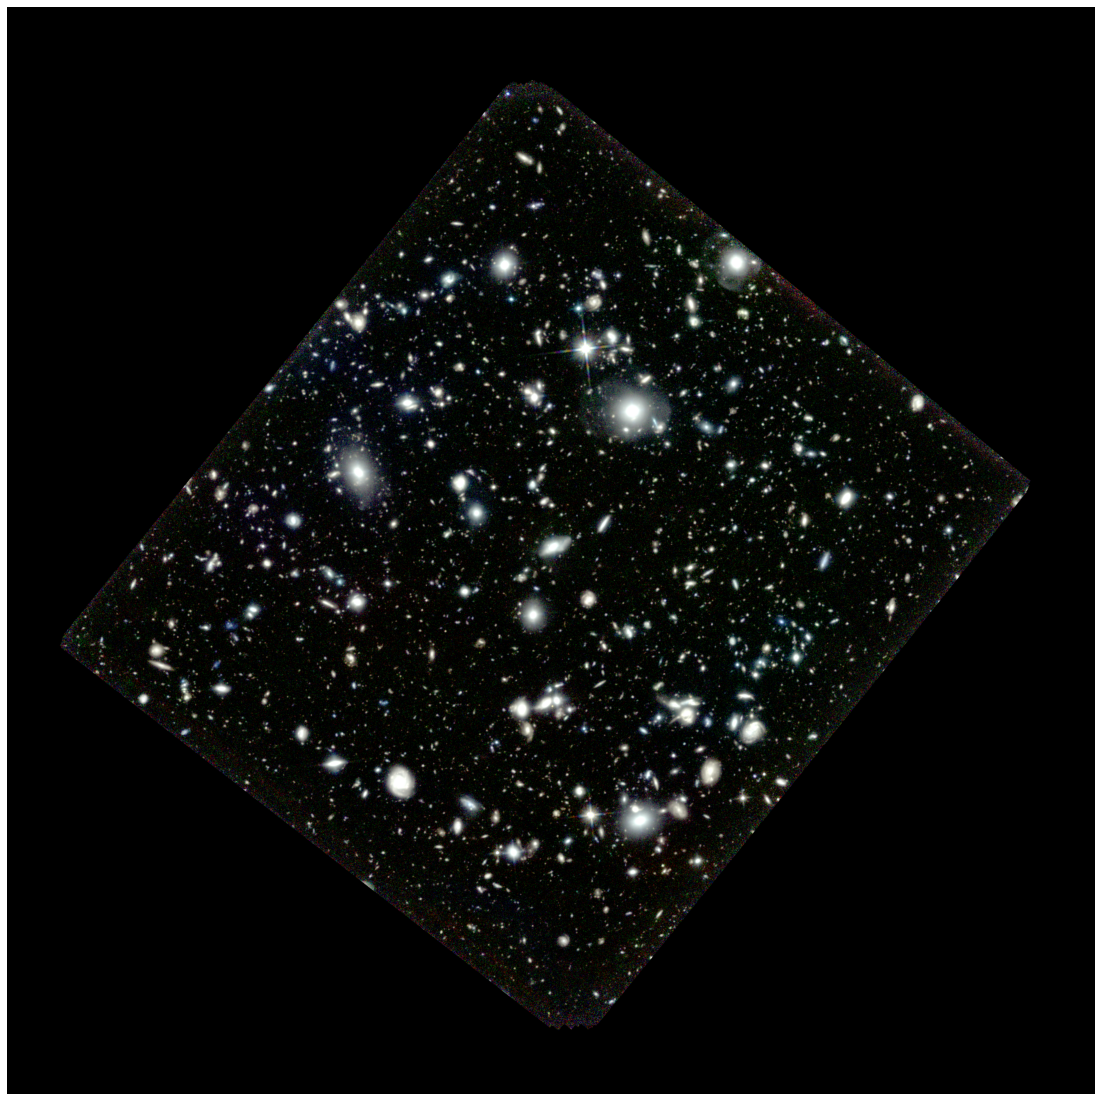

In [19]:
def rescale_img(data):
    pdata_tmp = data.copy()
    mean = np.nanmean(pdata_tmp)
    vplmin = mean / 2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(mean * 100.)
    pdata_tmp[pdata_tmp < vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    
    return pdata_tmp, vpmin, vpmax

hdul125 = astropy.io.fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
hdul160 = astropy.io.fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

data125 = hdul125[0].data
data160 = hdul160[0].data

d105Res, d105Min, d105Max = rescale_img(data)
d125Res, d125Min, d125Max = rescale_img(data125)
d160Res, d160Min, d160Max = rescale_img(data160)

d105Res[d105Res < d105Min] = d105Min
d105Res[d105Res > d105Max] = d105Max

d125Res[d125Res < d125Min] = d125Min
d125Res[d125Res > d125Max] = d125Max

d160Res[d160Res < d160Min] = d160Min
d160Res[d160Res > d160Max] = d160Max

rgb = np.zeros((d105Res.shape[0], d105Res.shape[1], 3))
rgb[:,:,0] = (d105Res - d105Min) / (d105Max - d105Min)
rgb[:,:,1] = (d125Res - d125Min) / (d105Max - d125Min)
rgb[:,:,2] = (d160Res - d160Min) / (d160Max - d160Min)

f, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.axis('off')
ax.imshow(rgb)

plt.savefig("rgb.png", format='png')